In [1]:
import os
import numpy as np
import scipy.io
import pywt

from scipy.signal import hilbert, freqz
from matplotlib import pyplot as plt

from typing import List, Tuple

# Functions

In [41]:
def Load(file: str) -> Tuple[List]:

    DATA = scipy.io.loadmat(os.path.join('Data', file))
    x = DATA['bearing']['gs'][0][0]
    fs = DATA['bearing']['sr'][0][0][0]
    time = np.transpose(np.arange(0, len(x)) / fs)

    return x, fs, time, DATA


def PSD(f: List, time: List, num: int) -> Tuple[List]:

    dt = abs(time[2] - time[1])
    n = len(time[:num])
    fhat = np.fft.fft(f[:num], n)
    freq = (1/(dt*n))*np.arange(n)
    psd = fhat*np.conj(fhat) / n
    L = np.arange(1, np.floor(n/2), dtype='int')

    return freq, psd, L

def plot_psd(freq, psd, L, title=''):

    plt.figure()
    plt.plot(freq[L], psd[L])
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title(f'PSD: {title}')




def Spec(f: List, fs: int, title: str=""):

    plt.figure()
    plt.title(title)
    plt.specgram(f, NFFT=1024, Fs=fs, noverlap=120,cmap='jet')
    plt.colorbar()


def wavelet_filter(coefficients, wavelet) -> List:
    
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coefficients)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

    keep = 0.05

    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec')

    # Plot reconstruction
    Arecon = pywt.waverec(coeffs_filt,wavelet=wavelet)

    return Arecon


def env_spectrum(x, fs):

    analytic_signal = hilbert(x)
    
    envelope = np.abs(analytic_signal)
    
    f_env = np.fft.fftfreq(len(envelope), d=1/fs)
    p_env = np.abs(np.fft.rfft(envelope) / len(x))
    
    
    x_env = envelope
    
    return p_env, f_env, x_env, 


def plot_env_spectrum(x_env, f_env, p_env, time):

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.xlim(0.04, 0.06)
    plt.plot(time, x_env)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')
    num = int(len(time)*0.001)
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(x_env)], x_env)
    plt.xlim(0.04, 0.06)
    # plt.ylim(0, 1)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')

def plot_env_spectrum_analysis(f_env, p_env, BP):
    
    ncomb = 10
    harmonics = dict(values=[k * BP["BPFI"] for k in range(1, ncomb + 1)], name="BPFI")

    plt.figure()
    a = next((index for index, value in enumerate(f_env) if value > 1000), -1)
    plt.plot(f_env[3:a], p_env[3:a], label='Envelope Spectrum')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel('Peak Amplitude')
    plt.xlim(0, 1000)
    plt.ylim( 0, 0.5)
    plt.vlines(harmonics['values'], 0, 0.5, colors='r', linestyles='--', label=harmonics['name'])
    plt.legend(framealpha=1)



# Analysis

## Inner Fault 1

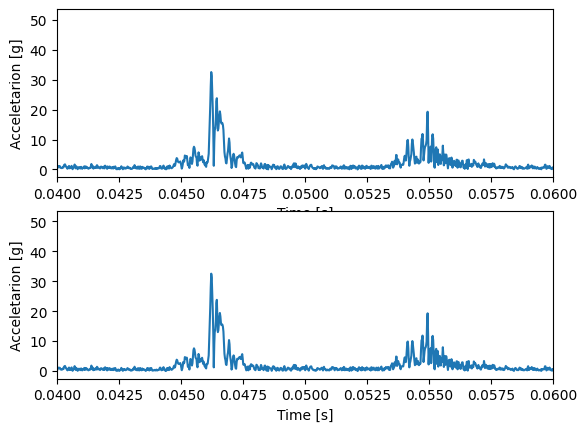

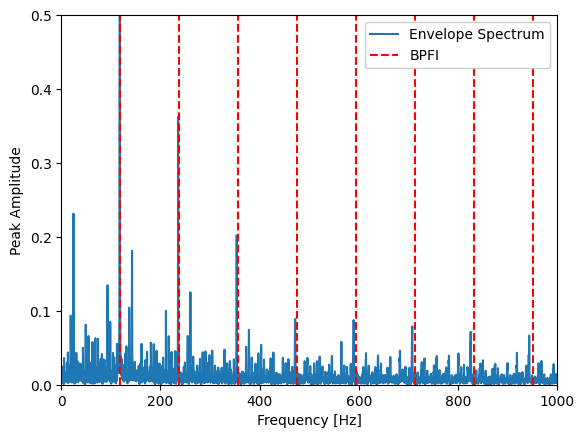

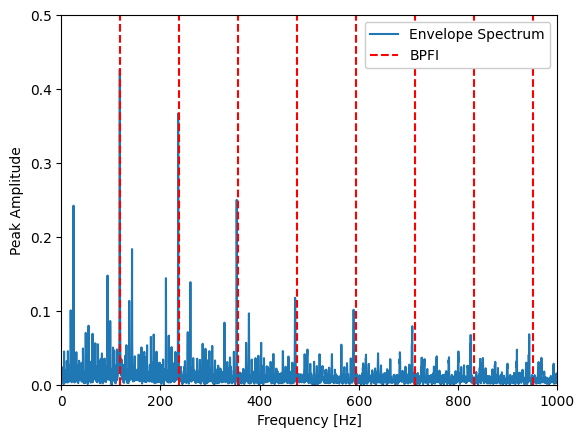

In [45]:
file_to_load = 'InnerRaceFault_vload_1.mat'
title = file_to_load.split('.')[0]


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)



num = int(len(t_IRF_1)*0.001)

freq, psd, L = PSD(x_IRF_1, t_IRF_1, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(x_IRF_1[:num])[0], f_IRF_1[0], title)

p_env, f_env, x_env = env_spectrum(np.transpose(x_IRF_1[:])[0],  f_IRF_1[0])

plot_env_spectrum(x_env, f_env, p_env, t_IRF_1)

plot_env_spectrum_analysis(f_env, p_env, IRFDATA)

# Wavelet

wavelet='db1'
scales = (1, len(x_IRF_1))
coeffs = pywt.wavedec(x_IRF_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon Inner Fault 1"

p_env, f_env, x_env = env_spectrum(np.transpose(recon)[0],  f_IRF_1[0])


plot_env_spectrum_analysis(f_env, p_env, IRFDATA)





## Baseline 1

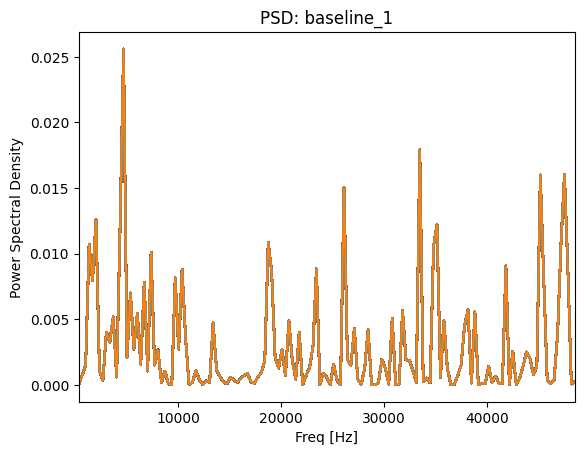

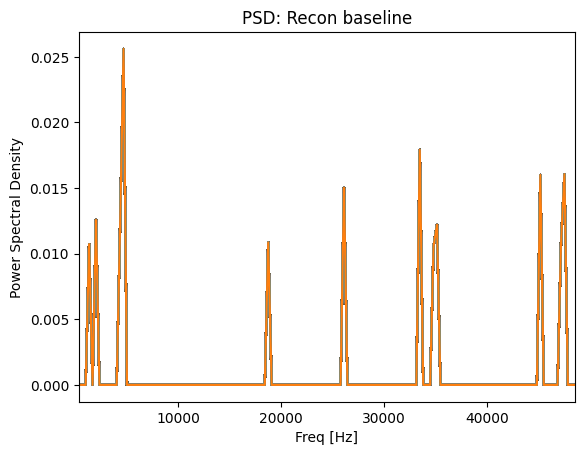

In [42]:
file_to_load = 'baseline_1.mat'
title = file_to_load.split('.')[0]

x_bsln_1, f_bsln_1, t_bsln_1, BSLN_DATA = Load(file_to_load)
num = int(len(t_bsln_1)*0.0005)

freq, psd, L = PSD(x_bsln_1, t_bsln_1, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_bsln_1[:num])[0], f_bsln_1[0], title)


#Wavelet test

wavelet='db1'
scales = (1, len(x_bsln_1))
coeffs = pywt.wavedec(x_bsln_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon baseline"

freq, psd, L = PSD(recon, t_bsln_1, num)

plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')


## Envelope Spectrum: Normal

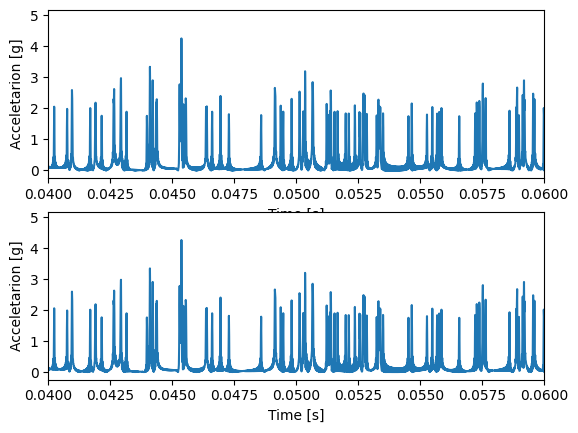

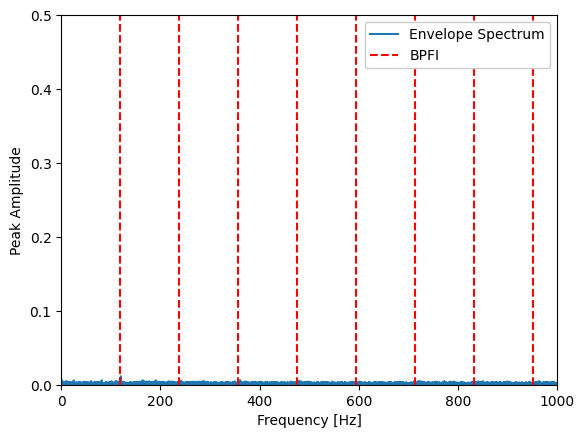

In [43]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_bsln_1)[0],  f_bsln_1[0])

plot_env_spectrum(x_env, f_env, p_env, t_bsln_1)

plot_env_spectrum_analysis(f_env, p_env, BSLN_DATA)
